In [1]:
import os

os.environ["CONFIG_PATH"] = "/home/locnt7"

os.environ["SPARK_SERVER"] = "SPARK@95"

In [2]:
import datetime as dt
import gc
import pandas as pd
import seaborn as sns
import scipy
import scipy.stats as st
from pdp.core import hdfs_utils, spark_utils
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window
from typing import List
import numpy as np
from datetime import timedelta,datetime,date
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc,f1_score,precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
%matplotlib inline


def date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [5]:
from pdp.core import spark_utils,hdfs_utils
from pyspark.sql import functions as F

import datetime as dt
NO_CORES=16
spark = spark_utils.get_spark_session(
    app_name="check transaction data",
    cores=NO_CORES,
    driver_memory=32,
    executor_memory=32,
    ui_port=9696,
    log_level="ERROR",
)

22/11/18 17:26:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Master: spark://10.60.37.95:7077
UI Web:       http://10.60.37.95:9696
Version:      3.1.2
App Name:     CHECK TRANSACTION DATA


In [3]:
df_pandas=pd.read_csv('files/transaction_data.csv',na_values=(" ","?","_","-1"))\
    .assign(TransactionTime=lambda x: x.TransactionTime.apply(lambda x: datetime.strptime(x,'%a %b %d %H:%M:%S IST %Y')))\
    .assign(ItemDescription=lambda x: x.ItemDescription.astype(str))\
    .assign(Country=lambda x: x.Country.astype(str))
# df_pandas.ItemDescription=df_pandas.ItemDescription.astype(str)
# df_pandas.Country=df_pandas.Country.astype(str)

In [6]:
df_pandas.describe()

,UserId,TransactionId,ItemCode,NumberOfItemsPurchased,CostPerItem
count,813658.000000,1.083818e+06,1.078226e+06,1.083818e+06,1.083818e+06
mean,321041.501975,6.159417e+06,6.616827e+05,2.865675e+01,9.498798e+00
std,35985.584256,1.476341e+05,4.513078e+05,6.542432e+02,2.308139e+03
min,259266.000000,5.900015e+06,4.200000e+01,-2.429850e+05,-1.526564e+04
25%,293013.000000,6.026856e+06,4.614960e+05,3.000000e+00,1.730000e+00
50%,318192.000000,6.166611e+06,4.754190e+05,9.000000e+00,2.880000e+00
75%,352611.000000,6.289569e+06,4.889640e+05,3.000000e+01,5.700000e+00
max,384027.000000,6.397457e+06,1.894494e+06,2.429850e+05,1.696285e+06


In [11]:
df_pandas.isna().sum()

UserId                    270160
TransactionId                  0
TransactionTime                0
ItemCode                    5592
ItemDescription                0
NumberOfItemsPurchased         0
CostPerItem                    0
Country                        0
dtype: int64

In [201]:
df_=spark.createDataFrame(df_pandas)

In [202]:
df_.printSchema()

root
 |-- UserId: double (nullable = true)
 |-- TransactionId: long (nullable = true)
 |-- TransactionTime: timestamp (nullable = true)
 |-- ItemCode: double (nullable = true)
 |-- ItemDescription: string (nullable = true)
 |-- NumberOfItemsPurchased: long (nullable = true)
 |-- CostPerItem: double (nullable = true)
 |-- Country: string (nullable = true)



In [220]:
df=df_.select(
    F.col('UserId').alias('user_id'),
    F.col('TransactionId').alias('trans_id'),
    F.col('TransactionTime').alias('timestamp'),
    F.col('ItemCode').alias('item_id'),
    F.col('ItemDescription').alias('item_metadata'),
    F.col('NumberOfItemsPurchased').alias('amount'),
    F.col('CostPerItem').alias('price_1'),
    F.col('Country').alias('country')
)

# preprocess

### Data understanding

In [116]:
df.select(F.min('amount'))

min(amount)
-242985


In [74]:
df.select(F.min('price'))

min(price)
-15265.64


In [77]:
df.select(F.max('timestamp'))

max(timestamp)
2028-02-18 14:36:00


In [80]:
df.filter(F.col('timestamp')>datetime(2022,12,31)).count()

5926

In [117]:
df.count()

1083818

In [221]:
df=df.dropna()\
    .filter(F.col('price_1')>0)\
    .filter(F.col('amount')>0)

Check date trans

In [222]:
df.withColumn('year',F.year('timestamp'))\
    .withColumn('month',F.month('timestamp'))\
    .groupBy('year','month').agg(
        F.countDistinct('trans_id').alias('num_trans')
    ).orderBy('year','month')

year,month,num_trans
2018,2,1198
2018,3,629
2018,4,1041
2018,5,1157
2018,6,1365
2018,7,1399
2018,8,1405
2018,9,1273
2018,10,1361
2018,11,1350


In [223]:
df=df.filter(F.col('timestamp')<datetime(2019,3,1))

In [205]:
df.count()

792940

In [206]:
df.select('user_id').distinct().count()

4334

In [207]:
df.select('item_id').distinct().count()

3194

In [90]:
df.groupBy('user_id').agg(
    F.count('trans_id').alias('num_trans'),
    F.countDistinct('item_id').alias('distinct_item'),
).orderBy('num_trans','distinct_item')

user_id,num_trans,distinct_item
328629,2,1
275226,2,1
377076,2,1
356790,2,1
316470,2,1
326802,2,1
323169,2,1
383628,2,1
288687,2,1
317478,2,1


Why min # transaction a user make is 2 --> need check

In [94]:
df_pandas.loc[lambda x:x.UserId==275226]

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
2787,275226,6179921,2018-10-10 11:12:00,471576,NATURAL SLATE CHALKBOARD LARGE,54,5.87,United Kingdom
311837,275226,6179921,2018-10-10 11:12:00,471576,NATURAL SLATE CHALKBOARD LARGE,54,5.87,United Kingdom
715106,275226,6183760,2018-10-15 07:50:00,471576,NATURAL SLATE CHALKBOARD LARGE,-12,5.87,United Kingdom
855368,275226,6183760,2018-10-15 07:50:00,471576,NATURAL SLATE CHALKBOARD LARGE,-12,5.87,United Kingdom


duplicate in transactionID --> error in inserting process

In [102]:
df.groupBy('trans_id').agg(
    F.countDistinct('user_id').alias('num_users')
).orderBy(F.desc('num_users')).head(1)

[Row(trans_id=6389801, num_users=1)]

No duplicate userid in 1 transaction id

In [104]:
df.groupBy('trans_id').agg(
    F.count('user_id').alias('num'),
).orderBy(F.desc('num')).head(5)

[Row(trans_id=6339729, num=1082),
 Row(trans_id=6371156, num=1064),
 Row(trans_id=6387997, num=1056),
 Row(trans_id=6360970, num=882),
 Row(trans_id=6309336, num=868)]

There some mistake, so every item in transaction is duplicate

### Data exploration

In [224]:
df=df.drop_duplicates()\
    .withColumn('user_id',F.col('user_id').cast(T.IntegerType()))\
    .withColumn('item_id',F.col('item_id').cast(T.IntegerType()))

In [213]:
df.count()

391249

<AxesSubplot:xlabel='country'>

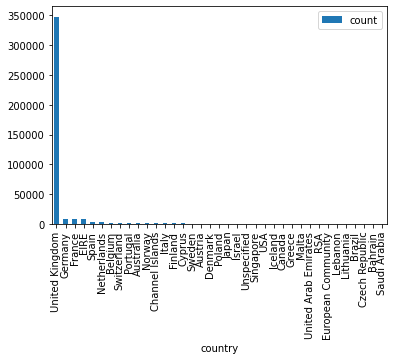

In [125]:
df_country_trans=df.groupby('country').count().orderBy(F.desc('count')).toPandas()
df_country_trans=df_country_trans.set_index('country')
df_country_trans.plot.bar()

In [150]:
df.withColumn('cost',F.col('amount')*F.col('price_1')).orderBy(F.desc('cost'))

user_id,trans_id,timestamp,item_id,item_metadata,amount,price_1,country,cost
288687,5900323,2018-02-12 06:37:00,465780,RETROSPOT LAMP,24,1696285.44,United Kingdom,4.071085056E7
345366,6396313,2019-02-20 05:15:00,500703,"PAPER CRAFT , LIT...",242985,2.88,United Kingdom,699796.7999999999
259266,5955741,2018-04-01 06:01:00,486486,MEDIUM CERAMIC TO...,222645,1.44,United Kingdom,320608.8
317058,6120884,2018-08-22 11:28:00,472542,PICNIC BASKET WIC...,180,896.31,United Kingdom,161335.8
366450,6241653,2018-12-02 07:05:00,488103,SET OF TEA COFFEE...,4236,6.99,United Kingdom,29609.64
330729,6055071,2018-06-30 09:20:00,443268,FAIRY CAKE FLANNE...,9342,2.9,United Kingdom,27091.8
330729,5948965,2018-03-25 08:55:00,443268,FAIRY CAKE FLANNE...,9342,2.9,United Kingdom,27091.8
307566,6303033,2019-01-08 08:11:00,484764,RABBIT NIGHT LIGHT,7200,2.88,Netherlands,20736.0
330729,5948965,2018-03-25 08:55:00,1787583,WHITE HANGING HEA...,5790,3.52,United Kingdom,20380.8
330729,6055071,2018-06-30 09:20:00,1787583,WHITE HANGING HEA...,5790,3.32,United Kingdom,19222.8


In [153]:
df.filter(F.col('item_id')==465780)

user_id,trans_id,timestamp,item_id,item_metadata,amount,price_1,country
297780,6138341,2018-09-05 08:14:00,465780,RETROSPOT LAMP,6,13.74,United Kingdom
313131,6011599,2018-05-26 08:15:00,465780,RETROSPOT LAMP,3,13.74,EIRE
272097,5940209,2018-03-18 08:18:00,465780,RETROSPOT LAMP,6,13.74,United Kingdom
370608,6105275,2018-08-12 07:21:00,465780,RETROSPOT LAMP,3,13.74,United Kingdom
371217,6283244,2018-12-26 08:34:00,465780,RETROSPOT LAMP,18,13.74,United Kingdom
313131,5906725,2018-02-14 10:04:00,465780,RETROSPOT LAMP,12,13.74,EIRE
343602,6228233,2018-11-21 10:47:00,465780,RETROSPOT LAMP,6,13.74,United Kingdom
382725,6159098,2018-09-24 11:29:00,465780,RETROSPOT LAMP,12,13.74,United Kingdom
285243,6151222,2018-09-18 06:40:00,465780,RETROSPOT LAMP,6,13.74,United Kingdom
353829,6111468,2018-08-18 05:16:00,465780,RETROSPOT LAMP,6,13.74,United Kingdom


In [ ]:
count_trans_per_item=df.groupBy('item_id').agg(
    F.count('trans_id').alias('count')
).select('count').rdd.flatMap(lambda x:x).collect()

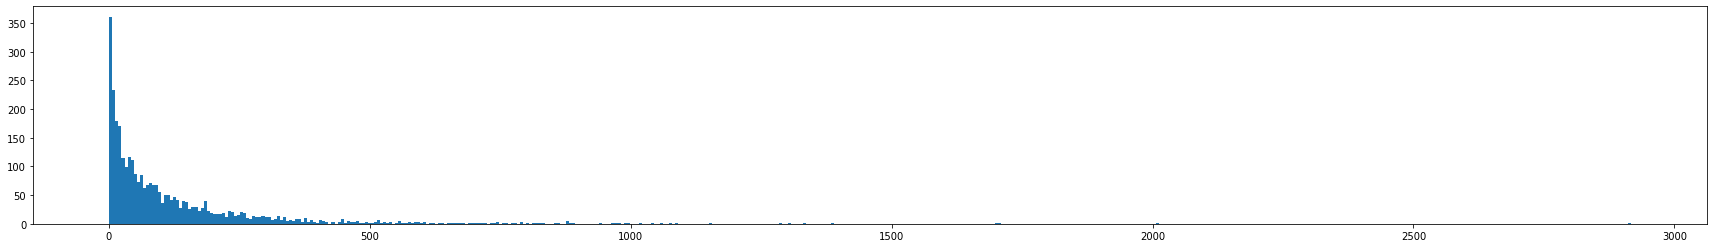

count    3194.000000
mean      122.153413
std       177.323160
min         1.000000
2%          1.000000
4%          2.000000
6%          3.000000
8%          4.000000
10%         6.000000
12%         7.000000
14%         8.000000
16%        10.000000
18%        12.000000
20%        14.000000
22%        16.000000
24%        18.000000
26%        20.180000
28%        23.000000
30%        25.000000
32%        28.760000
34%        31.000000
36%        35.000000
38%        38.000000
40%        42.000000
42%        45.000000
44%        49.000000
46%        53.000000
48%        59.000000
50%        63.000000
52%        68.000000
54%        74.000000
56%        78.080000
58.0%      85.000000
60%        90.000000
62%        95.000000
64%       103.000000
66%       111.000000
68%       119.000000
70%       128.000000
72%       137.000000
74%       147.820000
76%       159.680000
78%       173.000000
80%       185.000000
82%       202.260000
84%       223.120000
86%       242.980000
88%       267

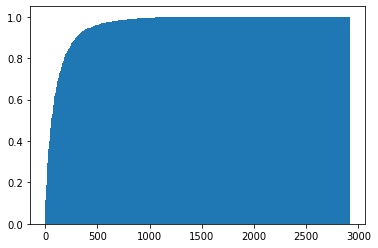

In [179]:
plt.figure(figsize=(30,4))
plt.hist(count_trans_per_item,bins=500);
plt.show()
plt.hist(count_trans_per_item,bins=500,cumulative=True,density=True)
pd.Series(count_trans_per_item).describe(
    percentiles=[0.02*x for x in range(1,50)]
)

In [225]:
df_range=df.groupBy('item_id').agg(
    F.percentile_approx('price_1',0.75).alias('rd_quantile'),
    F.percentile_approx('price_1',0.25).alias('st_quantile'),
).withColumn('IQR',F.col('rd_quantile')-F.col('st_quantile'))\
.withColumn('upper_bound',F.col('rd_quantile')+1.5*F.col('IQR'))\
.withColumn('lower_bound',F.col('st_quantile')-1.5*F.col('IQR'))\
.select('item_id','upper_bound','lower_bound').cache()

In [226]:
df_clean=df.join(df_range,on='item_id')\
    .filter(F.col('price_1')<=F.col('upper_bound'))\
    .filter(F.col('price_1')>=F.col('lower_bound')).drop('upper_bound','lower_bound').cache()

## Analysis


### Amount and price per month

In [229]:
amount_price_per_month_pd=df_clean.withColumn('cost',F.col('price_1')*F.col('amount'))\
    .withColumn('year',F.year('timestamp'))\
    .withColumn('month',F.month('timestamp'))\
    .groupBy('year','month').agg(
        F.sum('amount').alias('num_item_purchased'),
        F.sum('cost').alias('price')
    ).orderBy('year','month').toPandas()

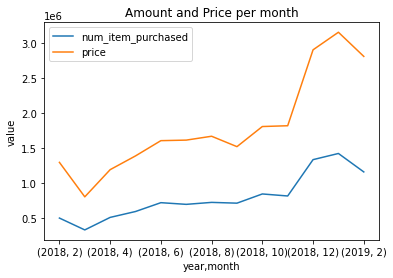

In [241]:
amount_price_per_month_pd.set_index(['year','month']).plot();
plt.ylabel('value');
plt.title('Amount and Price per month');

### Report selling efficency

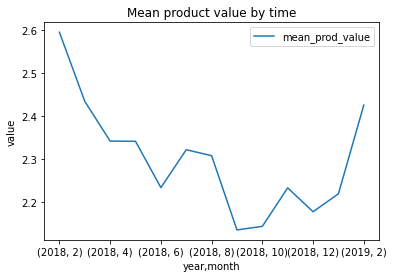

In [240]:
amount_price_per_month_pd\
    .assign(mean_prod_value=lambda x:x.price/x.num_item_purchased)\
    [['year','month','mean_prod_value']]\
    .set_index(['year','month']).plot();
plt.ylabel('value')
plt.title('Mean product value by time');


In [257]:
df_mean_revenue_per_item=df_clean.withColumn('cost',F.col('price_1')*F.col('amount'))\
    .withColumn('year',F.year('timestamp'))\
    .withColumn('month',F.month('timestamp'))\
    .groupBy('year','month','item_id').agg(
        F.sum('cost').alias('cost_this_month')
    ).orderBy('item_id','year','month').groupBy('item_id').agg(
        F.mean('cost_this_month').alias('mean_over_month'),
        F.collect_list('cost_this_month').alias('list_cost'),
        F.count('month').alias('num_sample'),
        F.stddev_samp('cost_this_month').alias('std_')
    ).orderBy(F.desc('mean_over_month')).toPandas()

In [275]:
df_mean_revenue_per_item.assign(std_error=lambda x:x.std_/x.num_sample.apply(lambda x: np.sqrt(x)))\
.assign(upper_confidend_bound_975=lambda x:x.mean_over_month+np.abs(st.t.ppf(.025,x.num_sample))*x.std_error)\
.assign(lower_confidend_bound_975=lambda x:x.mean_over_month-np.abs(st.t.ppf(.025,x.num_sample))*x.std_error)\
.sort_values(['lower_confidend_bound_975'],ascending=False)
        

,item_id,mean_over_month,list_cost,num_sample,std_,std_error,upper_confidend_bound_975,lower_confidend_bound_975
1,1787079,33584.270769,"[9201.600000000006, 6293.7, 12222.900000000003...",13,19864.905274,5509.533427,45486.894096,21681.647443
3,1784937,18268.617692,"[7676.759999999993, 34582.80000000006, 19623.7...",13,8115.821950,2250.924014,23131.443381,13405.792004
4,470883,15462.276923,"[12672.0, 8712.0, 11985.600000000004, 16579.20...",13,4279.343973,1186.876471,18026.367649,12898.186197
5,998886,15059.814545,"[4945.320000000001, 13420.080000000004, 21361....",11,7787.346513,2347.973318,20227.668974,9891.960117
11,1782459,11823.840000,"[9912.239999999993, 5524.739999999997, 7069.13...",13,3718.649545,1031.367816,14051.974704,9595.705296
...,...,...,...,...,...,...,...,...
3187,1784790,4.560000,[4.5600000000000005],1,NaN,NaN,NaN,NaN
3190,1892184,3.540000,[3.54],1,NaN,NaN,NaN,NaN
3191,1891764,3.540000,[3.54],1,NaN,NaN,NaN,NaN
3192,446628,3.480000,[3.4799999999999995],1,NaN,NaN,NaN,NaN


### Number of bought product in window

In [287]:
all_columns=['user_id','timestamp','country']
threshold=30

In [333]:
df_purchased_30=df_clean.select('user_id',F.to_date('timestamp').alias('timestamp'),'country').distinct()\
.join(
    df_clean.select(
        'user_id',
        F.to_date('timestamp').alias('time_before'),
        F.col('amount').alias('amount_before')
    ),on='user_id')\
.filter(F.col('time_before')<=F.col('timestamp'))\
.withColumn('date_diff',F.datediff('timestamp','time_before'))\
.filter(F.col('date_diff')<=threshold)\
.groupBy(*all_columns).agg(I
    F.sum('amount_before').alias('NumberOfItemsPurchased_30days')
).cache()


In [335]:
df_purchased_30.filter(F.col('user_id')==348432).orderBy('timestamp')

user_id,timestamp,country,NumberOfItemsPurchased_30days
348432,2018-05-09,United Kingdom,1002
348432,2018-06-13,United Kingdom,639
348432,2018-08-03,United Kingdom,708
348432,2018-08-21,United Kingdom,1431
348432,2018-10-07,United Kingdom,1779
348432,2019-01-01,United Kingdom,516
348432,2019-01-21,United Kingdom,879
348432,2019-02-08,United Kingdom,1038
348432,2019-02-16,United Kingdom,2490


In [317]:
df_clean.filter(F.col('user_id')==348432)\
    .withColumn('date',F.to_date('timestamp'))\
    .groupBy('date').agg(
        F.sum('amount')
    ).orderBy('date')

date,sum(amount)
2018-05-09,1002
2018-06-13,639
2018-08-03,708
2018-08-21,723
2018-10-07,1779
2019-01-01,516
2019-01-21,363
2019-02-08,675
2019-02-16,1452


In [342]:
df_clean.filter(F.col('user_id')==348432).select('item_metadata').distinct().show(truncate=False,vertical=True)

-RECORD 0--------------------------------------------
 item_metadata | SET/3 RED GINGHAM ROSE STORAGE BOX  
-RECORD 1--------------------------------------------
 item_metadata | PACK OF 12 50'S CHRISTMAS TISSUES   
-RECORD 2--------------------------------------------
 item_metadata | BUNNY DECORATION MAGIC GARDEN       
-RECORD 3--------------------------------------------
 item_metadata | SET/10 PINK POLKADOT PARTY CANDLES  
-RECORD 4--------------------------------------------
 item_metadata | STORAGE TIN VINTAGE LEAF            
-RECORD 5--------------------------------------------
 item_metadata | PLAYING CARDS KEEP CALM & CARRY ON  
-RECORD 6--------------------------------------------
 item_metadata | STAR WOODEN CHRISTMAS DECORATION    
-RECORD 7--------------------------------------------
 item_metadata | SET/20 RED RETROSPOT PAPER NAPKINS  
-RECORD 8--------------------------------------------
 item_metadata | SILVER HEARTS TABLE DECORATION      
-RECORD 9-------------------